# Imports

In [1]:
import pandas as pd
import numpy as np

# Read Data

In [2]:
X_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_train_normalized.csv", index_col=[0])
X_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_test_normalized.csv", index_col=[0])
y_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_train.csv", index_col=[0])
y_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_test.csv", index_col=[0]).reset_index(drop=True)

In [3]:
X_train.head(5)

,Symbol,Volume,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,...,Adj Close 14-Day std Differenced,Adj Close 26-Day std Differenced,Adj Close 7-Day Upper Bollinger Band Differenced,Distance to Adj Close 7-Day Upper Bollinger Band Differenced,True Range Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,High Differenced,Low Differenced,Open Differenced
0,-1.439324,-0.326871,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,-0.387284,-0.412467,...,0.041515,0.037984,-0.002604,-0.016884,-0.066039,0.104504,-0.020330,0.008943,0.015877,0.062622
1,-1.069061,-0.344648,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,2.582087,-0.412467,...,-0.410893,-0.015098,0.023690,-0.111938,-0.141182,-0.090630,-0.107768,0.032258,0.030478,0.096788
2,1.641263,-0.295005,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,-0.387284,-0.412467,...,0.081853,0.002250,0.188618,0.000862,-0.002066,0.105746,0.125379,0.102205,0.158246,0.137784
3,-0.343346,0.285874,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,2.582087,-0.412467,...,0.162828,-0.007191,0.102354,0.062595,0.043600,0.091515,0.136523,0.094434,0.004925,0.076288
4,1.256190,-0.328472,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,2.534516,-0.387284,-0.412467,...,1.195841,-0.202535,1.265493,-0.284640,-0.679202,-1.099516,0.521058,0.755054,0.866425,0.817676


In [4]:
X_test.head(5)

,Symbol,Volume,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,...,Adj Close 14-Day std Differenced,Adj Close 26-Day std Differenced,Adj Close 7-Day Upper Bollinger Band Differenced,Distance to Adj Close 7-Day Upper Bollinger Band Differenced,True Range Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,High Differenced,Low Differenced,Open Differenced
0,-1.054250,-0.283809,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,-0.387284,2.424439,...,0.244619,-0.054833,0.193442,-0.988178,-0.460024,-0.458573,-0.961706,-0.123181,-0.779922,0.216366
1,0.449017,-0.359859,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,2.534516,-0.387284,-0.412467,...,-1.623606,-1.598235,-0.116220,-0.549677,-0.673831,-0.614296,-0.682605,0.832754,-0.079040,1.432648
2,1.419105,-0.198809,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,-0.387284,-0.412467,...,-4.366291,-2.195166,0.093043,-4.112427,3.947181,1.902798,-4.471950,1.435083,-4.328154,1.015831
3,-1.261598,-0.272044,-0.21136,-0.21136,-0.356345,-0.279992,-0.222173,-0.394553,-0.387284,-0.412467,...,5.267571,4.461425,4.610485,-12.390394,14.154228,10.022441,-10.617055,-3.111471,-14.261016,-12.872375
4,-0.128593,-0.255868,-0.21136,-0.21136,2.806268,-0.279992,-0.222173,-0.394553,-0.387284,-0.412467,...,0.039264,0.059860,0.030323,-0.411204,0.082851,0.121352,-0.433286,-0.263072,-0.294412,0.025041


In [5]:
y_train.head(5)

,1-week Forward Return Sign
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0


In [6]:
y_test.head(5)

,1-week Forward Return Sign
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


# Data Prep

LSTMs requires the data to be structured differently to most ML models


# Fit LSTM
Write explanation of LSTM

# Work my way up!
This section of code we will start with a simple 1 feature LSTM for 1 stock. Then we can do multiple features for 1 stock. Finally we can do multiple features for multiple stocks! Be patient! You've got this. Small steps are better that jumping ahead and not understanding.

## 1 Stock 1 Feature

In [7]:
# Get singular stock to use
stocks = X_train['Symbol'].unique()
stock = stocks[0]
stock

# Create dataframe with singular stock and singular feature (which will be the target)
df = X_train[X_train['Symbol'] == stock][['Adj Close 7-Day Upper Bollinger Band Differenced']].reset_index(drop=True)
df

,Adj Close 7-Day Upper Bollinger Band Differenced
0,-0.002604
1,0.016938
2,-0.006843
3,-0.028533
4,-0.037744
...,...
1347,-0.053359
1348,-0.053067
1349,-0.009339
1350,-0.013484


In [8]:
# Define lookback (window) period n (given volume at T - 1, T-2 , T-n, predict volume at T)
window = 5

# CONVERT TO SUPERVISED LEARNING PROBLEM
# Data structure is as below. On left we have volume at some times, and our target is on the right (volume at next time)
# [[[0], [1], [2], [3], [4], [5]]]    [6]
# [[[1], [2], [3], [4], [5], [6]]]    [7]
# [[[2], [3], [4], [5], [6], [7]]]    [8]
# ........

# Note that each volume value is wrapped in its own list. This is because when we get to the multivariate case, we can include more in each list (e.g. volume and price) so they won't just be 1 element lists
def df_to_X_y(df, window):
    
    # Convert dataframe to numpy
    df_as_np = df.to_numpy()
    
    # Array to store X and y
    X = []
    y = []
    
    # Loop through each index in the dataframe and get X and y
    for i in range(len(df_as_np)-window):
        # Get values in window and wrap each one in a list
        row = df_as_np[i: i+window]
        X.append(row)
        
        # Get the label (first value after the window)
        label = df_as_np[i + window][0]
        y.append(label)
    
    return np.array(X), np.array(y)

In [9]:
X, y = df_to_X_y(df=df, window=window)
print(X.shape, y.shape)
print(X)
print(y)

(1347, 5, 1) (1347,)
[[[-0.00260446]
  [ 0.0169385 ]
  [-0.00684268]
  [-0.02853307]
  [-0.03774383]]

 [[ 0.0169385 ]
  [-0.00684268]
  [-0.02853307]
  [-0.03774383]
  [-0.06029836]]

 [[-0.00684268]
  [-0.02853307]
  [-0.03774383]
  [-0.06029836]
  [-0.0291746 ]]

 ...

 [[-0.41880868]
  [-0.15321295]
  [-0.06333387]
  [-0.05335927]
  [-0.05306661]]

 [[-0.15321295]
  [-0.06333387]
  [-0.05335927]
  [-0.05306661]
  [-0.00933891]]

 [[-0.06333387]
  [-0.05335927]
  [-0.05306661]
  [-0.00933891]
  [-0.01348382]]]
[-0.06029836 -0.0291746  -0.02900769 ... -0.00933891 -0.01348382
  0.08675373]


In [10]:
X_train, y_train = X[:900], y[:900]
X_val, y_val = X[900:1100], y[900:1100]
X_test, y_test = X[1100:], y[1100:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(900, 5, 1) (900,)
(200, 5, 1) (200,)
(247, 5, 1) (247,)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint # Save best model 
from tensorflow.keras.losses import MeanSquaredError # Loss function
from tensorflow.keras.optimizers import Adam

2024-06-03 15:16:52.151449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 15:16:52.151691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 15:16:52.323232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# Build up layers of network
model1 = Sequential()
model1.add(
    InputLayer((window, 1)) # Each piece of info is a window x 1 vector (containing the volumes in the window)
)
model1.add(
    LSTM(64) # Check what the 64 means. Can use GRU as well as LSTM
)
model1.add(
    Dense(8, 'relu') # Check what this layer is for
)
model1.add(
    Dense(1, 'linear') # Think this is output layer but need to check. I.e. it spits out predicted volume
)

# Can see the model takes in 5x1 vector, converts it to a 64 elemtns, then 8, then 1 which is our output
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Save model
cp = ModelCheckpoint(
    'model1.keras',
    save_best_only=True
)

In [14]:
# Compile model
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[MeanSquaredError()]
)

# Fit model with validation set. Notice loss decreasng
model1.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val), # Validation data
    epochs=50, # 10 runs through training dataset
    callbacks=[cp] # At end of every epoch, save the model if loss was lower than before
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0103 - val_mean_squared_error: 0.0130
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0102 - val_mean_squared_error: 0.0127
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0102 - val_mean_squared_error: 0.0124
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mean_squared_error: 0.0114 - val_loss: 0.0101 - val_mean_squared_error: 0.0124
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0101 - val_mean_squared_error: 0.0123
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0100 - val_mean_squared_error: 0.0122
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0100 - val_mean

In [15]:
# Load model back
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/model1.keras')

In [16]:
# Make preds on training set
test_preds = model1.predict(X_test).flatten()

# Compare to actuals
test_results = pd.DataFrame(
    data={
        'Test Preds': test_preds,
        'Actuals': y_test
    }
)
test_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,Test Preds,Actuals
0,0.020500,-0.015227
1,0.015617,0.186184
2,0.023592,0.201458
3,0.023592,0.103540
4,0.023592,0.159907
...,...,...
242,-0.021583,-0.053359
243,0.021597,-0.053067
244,0.021342,-0.009339
245,-0.005578,-0.013484


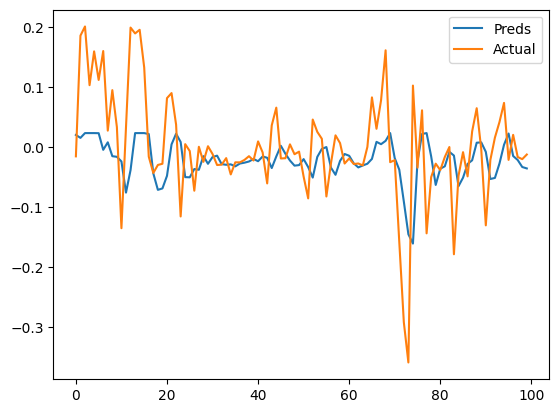

In [17]:
# Seems to be a lag - probably due to autoregressive nature
import matplotlib.pyplot as plt
plt.plot(test_results['Test Preds'][:100], label='Preds')
plt.plot(test_results['Actuals'][:100], label='Actual')
plt.legend()
plt.show()

# TODO: 1 STOCK MANY FEATURES AND ACTUAL TARGET